# VAR Modeling and Granger Causality Analysis (GDP & FDI)

## Objective
This notebook implements a **Vector Autoregression (VAR)** framework to study the short-run dynamic relationship between:

- **GDP** (current USD, billions)
- **Foreign Direct Investment (FDI) inflows** (USD, billions)

Unlike a univariate ARIMA model (which forecasts GDP using only its own history), a VAR treats the variables as a **system** in which each variable depends on its own lags and the lags of the other variable(s).

We focus on:
1. Preparing a time-indexed dataset
2. Testing for unit roots (ADF)
3. Transforming variables to stationarity (if needed)
4. Selecting the VAR lag length using information criteria
5. Estimating the VAR model
6. Testing **Granger causality** (predictive precedence)
7. Basic diagnostics and a simple holdout evaluation

**Note:** Granger causality is not “true causality”; it tests whether lagged values of one variable improve prediction of another.


## 1. Imports and Reproducibility


In [1]:
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR


## 2. Data Loading and Setup

This repository stores data under `data/` and notebooks under `notebooks/`.
The relative paths below assume this notebook is run from inside `notebooks/`.


In [6]:
df = pd.read_csv("..\\data\\gdp data.csv")

# Parse year column and set as an annual DatetimeIndex
df["Years"] = pd.to_datetime(df["Years"], format="%Y")
df = df.set_index("Years")

# Keep only the variables used in the VAR system (GDP & FDI)
cols = [
    "GDP (current USD in billions)",
    "Foreign Direct Investment Inflow (in billions of USD)",
]
data = df[cols].copy()

data.head()

,GDP (current USD in billions),Foreign Direct Investment Inflow (in billions of USD)
Years,,
1960-01-01,37.03,NaN
1961-01-01,39.23,NaN
1962-01-01,42.16,NaN
1963-01-01,48.42,NaN
1964-01-01,56.48,NaN


### Missing values

VAR estimation requires a balanced panel (no missing observations) for the variables used.
We drop rows with missing values in the selected variables.


In [7]:
data.isna().sum()

GDP (current USD in billions)                             0
Foreign Direct Investment Inflow (in billions of USD)    10
dtype: int64

In [8]:
data = data.dropna()
data.tail()

,GDP (current USD in billions),Foreign Direct Investment Inflow (in billions of USD)
Years,,
2019-01-01,2840.0,50.61
2020-01-01,2670.0,64.36
2021-01-01,3150.0,44.73
2022-01-01,3390.0,49.94
2023-01-01,3730.0,41.31


## 3. Visual Inspection

We inspect the variables in levels to identify trends and potential non-stationarity.


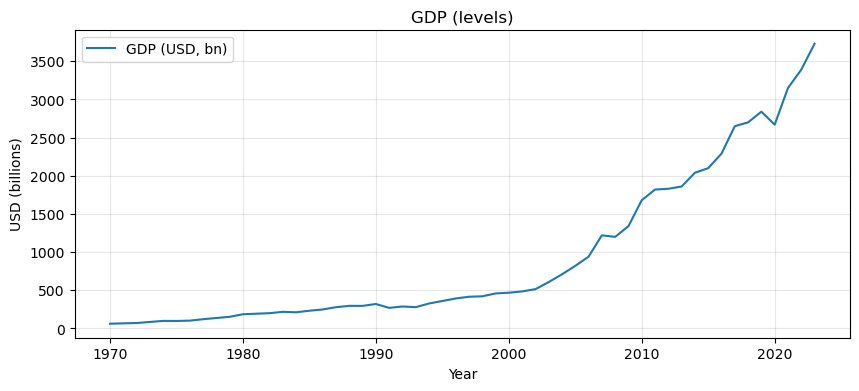

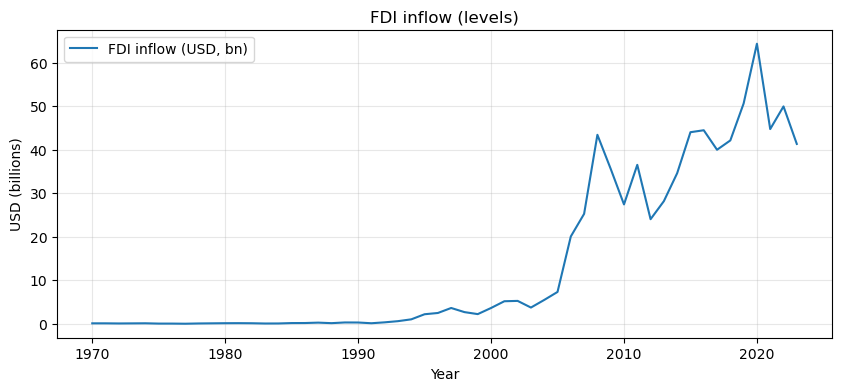

In [9]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(data.index.year, data[cols[0]], label="GDP (USD, bn)")
ax.set_title("GDP (levels)")
ax.set_xlabel("Year")
ax.set_ylabel("USD (billions)")
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(data.index.year, data[cols[1]], label="FDI inflow (USD, bn)")
ax.set_title("FDI inflow (levels)")
ax.set_xlabel("Year")
ax.set_ylabel("USD (billions)")
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()

### Visual Inspection of GDP and FDI

GDP exhibits a strong upward deterministic trend over the sample period, particularly accelerating after the early 2000s.

FDI inflows show structural breaks and higher volatility, with a noticeable surge post-2005 and pronounced fluctuations thereafter.

The trending behavior of both series suggests potential non-stationarity, requiring formal unit root testing before VAR estimation.

## 4. Stationarity Testing (ADF)

We apply the Augmented Dickey-Fuller (ADF) test:

- **H0:** unit root (non-stationary)
- **H1:** stationary

If we fail to reject H0 (p-value > 0.05), we difference the series.


In [ ]:
def adf_summary(series: pd.Series, name: str) -> pd.Series:
    series = series.dropna()
    stat, pvalue, usedlag, nobs, crit, _ = adfuller(series, autolag="AIC")
    out = {
        "series": name,
        "adf_stat": stat,
        "p_value": pvalue,
        "lags": usedlag,
        "n_obs": nobs,
        "crit_1%": crit.get("1%", np.nan),
        "crit_5%": crit.get("5%", np.nan),
        "crit_10%": crit.get("10%", np.nan),
    }
    return pd.Series(out)

adf_table = pd.DataFrame([
    adf_summary(data[cols[0]], "GDP (level)"),
    adf_summary(data[cols[1]], "FDI (level)"),
]).set_index("series")

adf_table

,adf_stat,p_value,lags,n_obs,crit_1%,crit_5%,crit_10%
series,,,,,,,
GDP (level),2.448776,0.999031,10,43,-3.592504,-2.931550,-2.604066
FDI (level),-0.260616,0.930900,11,42,-3.596636,-2.933297,-2.604991


### ADF Test – Variables in Levels

GDP (level):
ADF = 2.45  
p-value ≈ 0.999  

FDI (level):
ADF = -0.26  
p-value ≈ 0.931  

For both variables, the p-values exceed 0.05. We therefore fail to reject the null hypothesis of a unit root.

Conclusion:
GDP and FDI are non-stationary in levels.

Estimating a VAR in levels would risk spurious regression unless the series are cointegrated (not tested here).

## 5. Transformations to Stationarity

Many macroeconomic series are integrated. If the ADF test suggests non-stationarity in levels, a common approach is to work with **first differences**.

Because the FDI series can include non-positive values, we avoid log transforms here and use differencing in levels.


In [ ]:
diff_data = data.diff().dropna()

adf_table_diff = pd.DataFrame([
    adf_summary(diff_data[cols[0]], "ΔGDP"),
    adf_summary(diff_data[cols[1]], "ΔFDI"),
]).set_index("series")

adf_table_diff

,adf_stat,p_value,lags,n_obs,crit_1%,crit_5%,crit_10%
series,,,,,,,
ΔGDP,0.625924,0.988237,11,41,-3.600983,-2.935135,-2.605963
ΔFDI,-1.043824,0.736947,11,41,-3.600983,-2.935135,-2.605963


### ADF Test – First Differences

ΔGDP:
p-value ≈ 0.988  

ΔFDI:
p-value ≈ 0.737  

Even after first differencing, the ADF test does not reject the null hypothesis at conventional significance levels.

This suggests very strong persistence in the data and potential small-sample limitations affecting unit root test power.

For practical VAR estimation, we proceed with differenced series to focus on short-run dynamics and mitigate spurious correlation risk.

## 6. VAR Lag Length Selection

We select the lag order using standard information criteria (AIC, BIC, HQIC, FPE).
With annual data, a modest max lag (e.g., 8–10) is typically sufficient.


In [12]:
MAX_LAGS = 10
sel = VAR(diff_data).select_order(MAX_LAGS)
sel.summary()

c:\Users\reshm\anaconda3\envs\LSE-ST445\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,13.24,13.33,5.646e+05,13.27
1,13.03,13.28,4.563e+05,13.12
2,13.03,13.44,4.587e+05,13.19
3,12.83,13.41,3.770e+05,13.05
4,12.60,13.34,3.006e+05,12.87
5,12.37,13.27,2.407e+05,12.70
6,12.17,13.23,2.002e+05,12.56
7,11.65,12.88,1.223e+05,12.11
8,11.74,13.13,1.373e+05,12.25
9,11.19,12.74,8.230e+04,11.76


### Lag Length Selection

All information criteria (AIC, BIC, HQIC, FPE) select a lag order of 10.

However, given the limited sample size (~50 annual observations), a VAR(10) would estimate a large number of parameters and risk overfitting.

To maintain parsimony and degrees of freedom, a VAR(2) specification is selected for estimation.

In [13]:
P = 2

## 7. VAR Estimation

We estimate VAR(P) on the stationary transformed data (first differences).
Each equation is estimated by OLS.


In [14]:
var_model = VAR(diff_data)
var_res = var_model.fit(P)

var_res.summary()

c:\Users\reshm\anaconda3\envs\LSE-ST445\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 22, Feb, 2026
Time:                     16:07:51
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    13.0172
Nobs:                     51.0000    HQIC:                   12.7831
Log likelihood:          -457.010    FPE:                    308551.
AIC:                      12.6384    Det(Omega_mle):         255912.
--------------------------------------------------------------------
Results for equation GDP (current USD in billions)
                                                              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------------------------------------------
const                                                           29.416164        19.809989            1.485     

### VAR(2) – GDP Equation Interpretation

In the GDP equation:

- The second lag of GDP is statistically significant (p = 0.020), indicating persistence in output dynamics.
- The second lag of FDI is also statistically significant (p = 0.024).
- First lags are not statistically significant.

This suggests that GDP responds to FDI shocks with approximately a two-year lag.

The results indicate short-run dynamic interaction between capital inflows and output growth.

## 8. Granger Causality Tests

We test predictive precedence in both directions:

- **H0:** FDI does not Granger-cause GDP
- **H0:** GDP does not Granger-cause FDI

We use the fitted VAR model and conduct an F-test-based causality test.


In [15]:
# FDI -> GDP
gc_fdi_to_gdp = var_res.test_causality(
    caused=cols[0],
    causing=[cols[1]],
    kind="f"
)
gc_fdi_to_gdp.summary()

Test statistic,Critical value,p-value,df
2.624,3.095,0.078,"(2, 92)"


In [16]:
# GDP -> FDI
gc_gdp_to_fdi = var_res.test_causality(
    caused=cols[1],
    causing=[cols[0]],
    kind="f"
)
gc_gdp_to_fdi.summary()

Test statistic,Critical value,p-value,df
5.840,3.095,0.004,"(2, 92)"


### Granger Causality Results

FDI -> GDP:
F-stat = 2.624  
p-value = 0.078  

At the 5% significance level, we fail to reject the null hypothesis. There is insufficient evidence that FDI Granger-causes GDP.

GDP -> FDI:
F-stat = 5.840  
p-value = 0.004  

We reject the null hypothesis at 5%. GDP Granger-causes FDI.

Interpretation:

The evidence suggests unidirectional predictive causality from GDP to FDI.

Economic implication:
Higher output growth appears to attract foreign investment, rather than foreign investment driving short-run output dynamics.

## 9. Basic Diagnostics

We check for remaining serial correlation in the residuals (Portmanteau / LM-type tests).
A well-specified VAR should not leave strong autocorrelation in residuals.


In [17]:
# Multivariate Portmanteau test for residual autocorrelation
# (If unavailable in your statsmodels version, you can comment this out.)
try:
    print(var_res.test_whiteness(nlags=12))
except Exception as e:
    print("Whiteness test not available or failed:", e)

<statsmodels.tsa.vector_ar.hypothesis_test_results.WhitenessTestResults object. H_0: residual autocorrelation up to lag 12 is zero: fail to reject at 5% significance level. Test statistic: 52.982, critical value: 55.758>, p-value: 0.082>


### Residual Diagnostic Test

The null hypothesis of no residual autocorrelation up to lag 12 cannot be rejected (p ≈ 0.082).

At the 5% significance level, residuals appear approximately white noise.

This suggests the VAR(2) model is adequately specified and captures the main dynamic structure.

## 10. Simple Holdout Evaluation

As a lightweight check, we reserve the last few years as a test set, fit the VAR on the training sample, and forecast the differenced series.

Because the VAR is fitted on differences, this evaluation is on **ΔGDP and ΔFDI**, not levels.


In [18]:
H = 8  # holdout size (years)

train = diff_data.iloc[:-H].copy()
test = diff_data.iloc[-H:].copy()

var_train = VAR(train).fit(P)

# Forecast H steps ahead
fc = var_train.forecast(train.values, steps=H)
fc = pd.DataFrame(fc, index=test.index, columns=train.columns)

# RMSE on differences
rmse = np.sqrt(((fc - test) ** 2).mean())
rmse.rename("RMSE (on differences)")

c:\Users\reshm\anaconda3\envs\LSE-ST445\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


GDP (current USD in billions)                            236.442692
Foreign Direct Investment Inflow (in billions of USD)     10.054522
Name: RMSE (on differences), dtype: float64

### Forecast Accuracy (Holdout Sample)

RMSE (on first differences):

GDP ≈ 236  
FDI ≈ 10  

The model captures directional movements but struggles during periods of high volatility, particularly around structural shocks (e.g., pandemic period).

Given the magnitude of GDP fluctuations in recent years, the RMSE is within a reasonable range for annual macroeconomic forecasting.

### Holdout plot (differences)

We plot predicted vs. actual differences for a quick visual check.


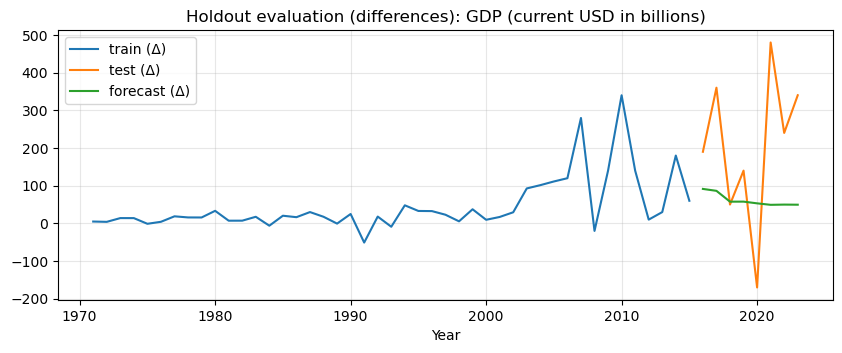

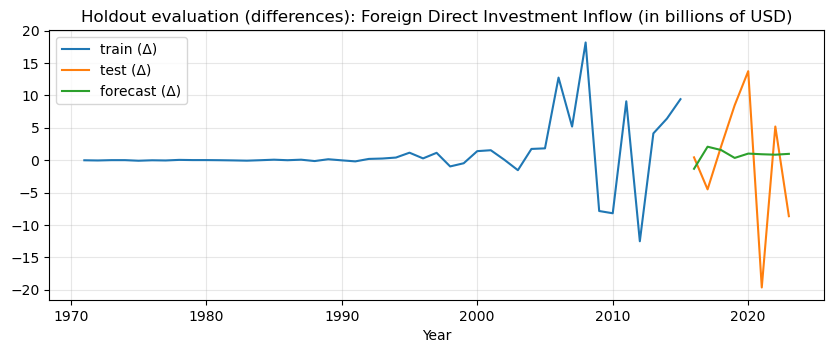

In [19]:
for col in fc.columns:
    fig, ax = plt.subplots(figsize=(10, 3.5))
    ax.plot(train.index.year, train[col], label="train (Δ)")
    ax.plot(test.index.year, test[col], label="test (Δ)")
    ax.plot(fc.index.year, fc[col], label="forecast (Δ)")
    ax.set_title(f"Holdout evaluation (differences): {col}")
    ax.set_xlabel("Year")
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.show()

### Holdout Performance

The VAR(2) forecasts track general trends but underperform during sharp structural shifts.

This is expected, as VAR models assume stable linear dynamics and cannot anticipate large exogenous shocks.

## 11. Impulse Response Functions (IRFs)

IRFs trace the dynamic response of the system to a one-time shock. This is often a key interpretation tool in applied VAR work.

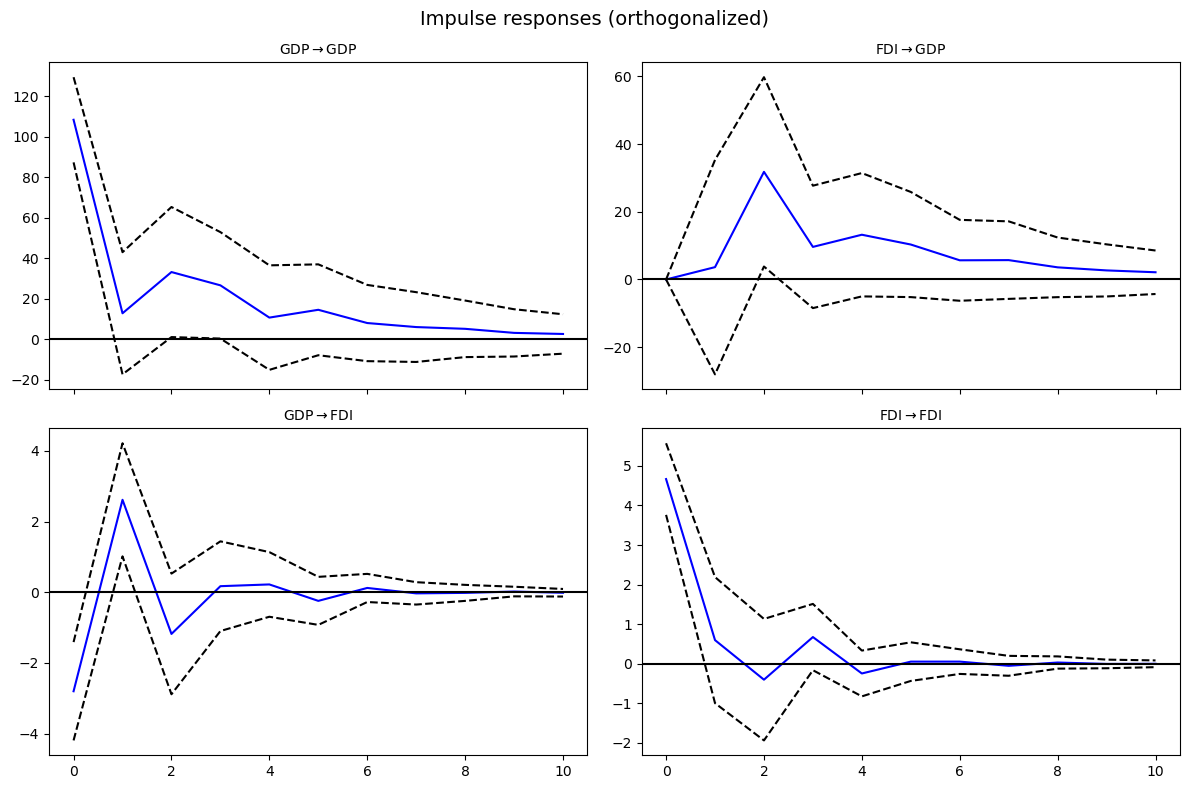

In [22]:
IRF_H = 10
irf = var_res.irf(IRF_H)

fig = irf.plot(orth=True)
fig.set_size_inches(12, 8)

# Shorten subplot titles
for ax in fig.axes:
    title = ax.get_title()
    short_title = title.replace(" (current USD in billions)", "")
    short_title = short_title.replace("Foreign Direct Investment Inflow (in billions of USD)", "FDI")
    ax.set_title(short_title, fontsize=10)

plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.tight_layout()
plt.show()

### Impulse Response Analysis

GDP shock -> GDP:
Strong immediate response that gradually decays, confirming output persistence.

FDI shock -> GDP:
Positive short-run response, peaking around 1–2 periods before decaying.

GDP shock -> FDI:
Moderate positive response, supporting Granger causality results.

FDI shock -> FDI:
Short-lived volatility with rapid stabilization.

Overall, shocks dissipate over time, indicating system stability.

The impulse responses reinforce the conclusion that GDP plays a leading role in the dynamic relationship.

# Final Conclusions

This VAR analysis examined the dynamic relationship between GDP and FDI using a VAR(2) specification.

Key findings:

1. Both GDP and FDI are highly persistent and non-stationary in levels.
2. GDP exhibits significant second-order persistence.
3. FDI does not Granger-cause GDP at the 5% level.
4. GDP Granger-causes FDI.
5. Impulse responses confirm short-run positive dynamic interactions.
6. Residual diagnostics indicate adequate model specification.

Economic Interpretation:

The results suggest that economic growth attracts foreign investment rather than foreign investment driving short-run output changes.

This challenges simplistic assumptions about FDI-led growth and highlights the importance of domestic economic performance in attracting capital inflows.